# ML Zoomcamp Mid-term Project - Stroke Prediction

## Load Libraries

In [223]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

from sklearn.metrics import  roc_auc_score, auc

## Data

### Stroke Prediction Dataset

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately [11% of total deaths](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

[This dataset](https://arxiv.org/pdf/1904.11280.pdf) is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information:

- `id`: unique identifier
- `gender`: “Male”, “Female” or “Other”
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn’t have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn’t have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: “No” or “Yes”
- `work_typ`e: “children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
- `Residence_type`: “Rural” or “Urban”
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: “formerly smoked”, “never smoked”, “smokes” or “Unknown”*
- `stroke`: 1 if the patient had a stroke or 0 if not

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We exlude `id` and group the categorical and numerical features to start exploration.

In [4]:
df.columns = df.columns.str.lower()
colnames = list(df.columns[1:,].values)
colnames

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

### Missing values checking

In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Column `bmi` has some missing values. 
Is it possible to impute missing values?
Or try to use some scenarios to fill the missing with mean, median or null to find the best result.

Let's explore the data further.

### Distribution of `stroke`

Text(0, 0.5, 'Number of Patients')

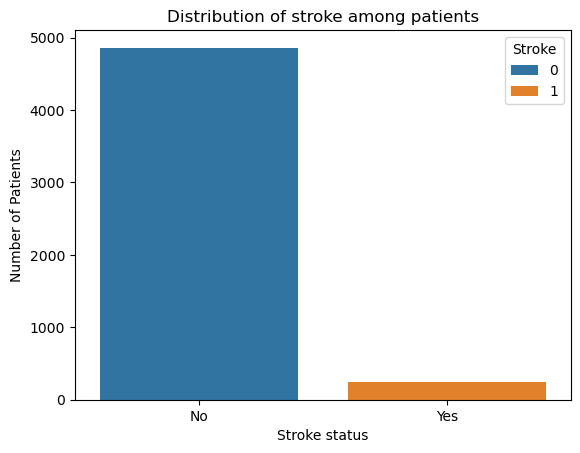

In [6]:
stroke_rate = df['stroke'].value_counts().reset_index()
stroke_rate.columns = ['Stroke', 'Count']

sns.barplot(
    data = stroke_rate,
    x = 'Stroke',
    y = 'Count',
    hue='Stroke'
)
plt.title('Distribution of stroke among patients')
plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
plt.xlabel('Stroke status')
plt.ylabel('Number of Patients')

In [7]:
len(df[df.stroke == 1]) / len(df) * 100

4.87279843444227

There is an imbalance in the response class of the stroke status. Only about 4.87% have stroke

### Independent features exploration

Dataset has both categorical and numerical features 

In [15]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
numerical = ['age', 'avg_glucose_level', 'bmi']

Let's see the distribution of numerical features first

In [9]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


Correlation matrix for the numerical features

In [147]:
corr_mtx = df[numerical].corr()
corr_mtx.style.background_gradient(cmap='coolwarm')

,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.333398
avg_glucose_level,0.238171,1.000000,0.175502
bmi,0.333398,0.175502,1.000000


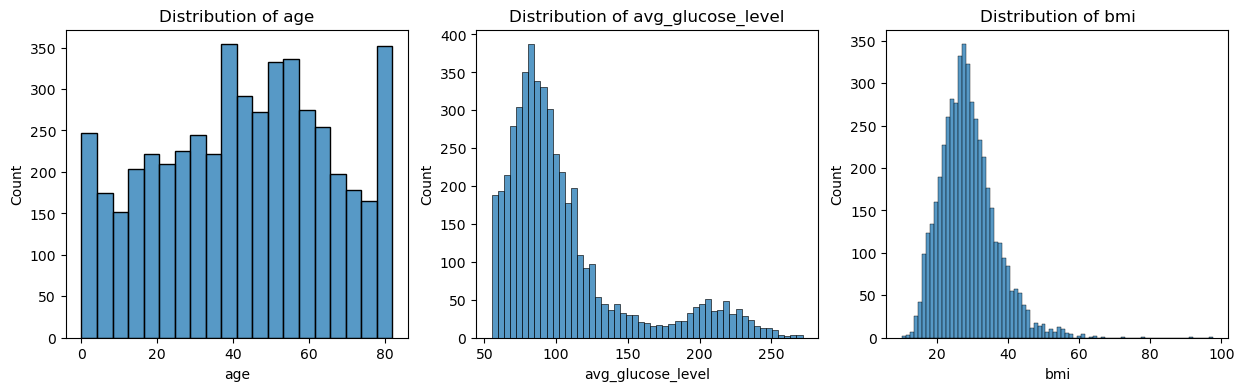

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
ax = ax.flatten()
for i, col in enumerate(numerical):
    sns.histplot(data = df[numerical].dropna(), x = col, ax = ax[i]).set_title(f'Distribution of {col}')

Based on the histograms above, the average patient is:
- Age: around 45 years old; middle-aged; wide-range from infancy to elderly
- Avg glucose level: median ~92; slighly elevated; may indicate pre-diabetic condition
- BMI: median around 28.1; overweight; suggests many patients are overweight or obese

The next one, let's explore categorical features!

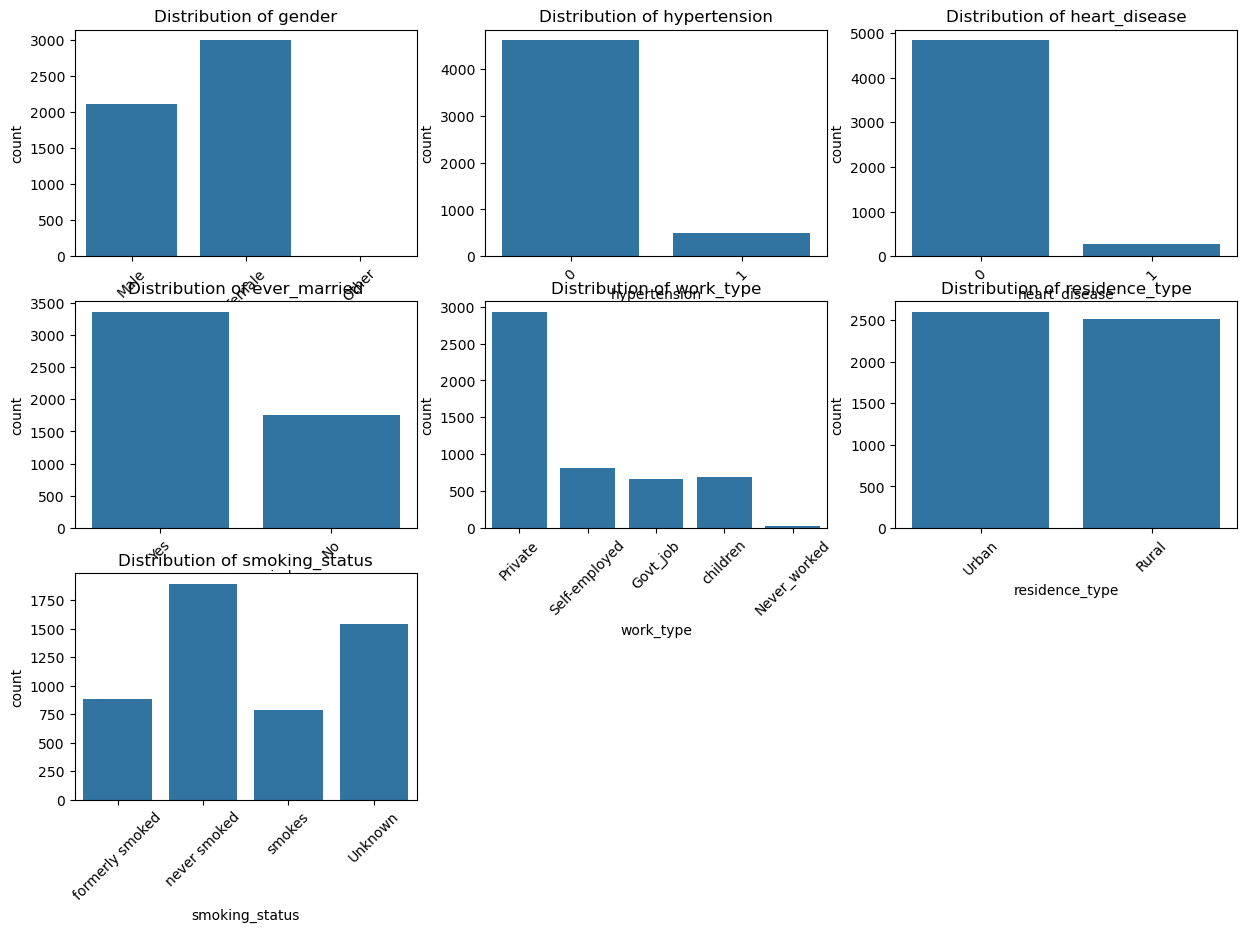

In [24]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
ax = ax.flatten()
for i, col in enumerate(categorical):
    sns.countplot(df[categorical], x = col, ax = ax[i])
    ax[i].set_title(f'Distribution of {col}')
    ax[i].tick_params(axis = 'x', rotation = 45)

for j in range(len(categorical), 9):
    ax[j].axis('off')

From the categorial features distribution, we can see:
- the dataset is female-dominant (~58%)
- most patients are healthy (no history of hypertension or heart disease). Maybe because most have never smoked
- most patients have been or are married and are employed, working in either private or government sectors or run a business

### Association between independent features and `stroke` status

In [28]:
stroke_group_median = df.groupby('stroke')[numerical].median().reset_index()
stroke_group_median.stroke = stroke_group_median['stroke'].map({0: 'No', 1: 'Yes'})
stroke_group_median

,stroke,age,avg_glucose_level,bmi
0,No,43.0,91.47,28.0
1,Yes,71.0,105.22,29.7


Patients who had stroke tend to be significantly older. They also show higher median glucose levels and slightly higher BMI. This suggests that age and glucose levels may be important factors associated with stroke risk.

In [29]:
# stroke rate by categorical features
for col in categorical:
    rate = df.groupby(col)['stroke'].mean().reset_index()
    rate.columns = [col, 'stroke_rate']
    rate['stroke_rate'] = rate['stroke_rate'].round(3) * 100
    print(f'\nStroke Rate by {col}:\n', rate)


Stroke Rate by gender:
    gender  stroke_rate
0  Female          4.7
1    Male          5.1
2   Other          0.0

Stroke Rate by hypertension:
    hypertension  stroke_rate
0             0          4.0
1             1         13.3

Stroke Rate by heart_disease:
    heart_disease  stroke_rate
0              0          4.2
1              1         17.0

Stroke Rate by ever_married:
   ever_married  stroke_rate
0           No          1.7
1          Yes          6.6

Stroke Rate by work_type:
        work_type  stroke_rate
0       Govt_job          5.0
1   Never_worked          0.0
2        Private          5.1
3  Self-employed          7.9
4       children          0.3

Stroke Rate by residence_type:
   residence_type  stroke_rate
0          Rural          4.5
1          Urban          5.2

Stroke Rate by smoking_status:
     smoking_status  stroke_rate
0          Unknown          3.0
1  formerly smoked          7.9
2     never smoked          4.8
3           smokes          5.3


The summary above shows that patients at risk of a stroke are:
- gender: male (higher risk) and female
- unhealthy: have smoke, have hypertension, have heart disease
- are/have married and are working professionals

Other gender, children, and unemployed groups have low stroke rates.

### BMI and rare categories (gender, work_type)

`Other` patients and patients who `never_worked` are very rare categories (which shows from their count in the data). I will explore these so as to know the appropriate way to handle them, else they add noise to the model.

In [31]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Only one patient for the `Other` patient and is a non-stroke case. We can probably drop this row as it won't contribute to the model.

In [32]:
df['bmi'].isnull()

0       False
1        True
2       False
3       False
4       False
        ...  
5105     True
5106    False
5107    False
5108    False
5109    False
Name: bmi, Length: 5110, dtype: bool

In [33]:
df['bmi_missing'] = df['bmi'].isnull()
df.groupby('bmi_missing')[['age', 'avg_glucose_level']].mean()

,age,avg_glucose_level
bmi_missing,,
False,42.865374,105.305150
True,52.049154,126.724627


In [34]:
for col in categorical:
    missing_rate = df.groupby(col)['bmi_missing'].mean().reset_index()
    missing_rate.columns = [col, 'Missing BMI Rate']
    missing_rate['Missing BMI Rate'] = (missing_rate['Missing BMI Rate'] * 100).round(3)
    print(f'\nMissing BMI Rate by {col}:\n', missing_rate)


Missing BMI Rate by gender:
    gender  Missing BMI Rate
0  Female             3.240
1    Male             4.917
2   Other             0.000

Missing BMI Rate by hypertension:
    hypertension  Missing BMI Rate
0             0             3.339
1             1             9.438

Missing BMI Rate by heart_disease:
    heart_disease  Missing BMI Rate
0              0             3.475
1              1            11.957

Missing BMI Rate by ever_married:
   ever_married  Missing BMI Rate
0           No             2.960
1          Yes             4.444

Missing BMI Rate by work_type:
        work_type  Missing BMI Rate
0       Govt_job             4.110
1   Never_worked             0.000
2        Private             3.897
3  Self-employed             5.372
4       children             2.329

Missing BMI Rate by residence_type:
   residence_type  Missing BMI Rate
0          Rural             3.779
1          Urban             4.083

Missing BMI Rate by smoking_status:
     smoking_status 

The missing value are not random. They cluster around:
- Older individuals
- Those with hypertension, heart disease, and higher glucose levels
- Smokers and employed individuals

### Preparation and Imputation

Next steps is to drop `id`, `Other` gender, then impute `bmi` using KNNImputer and one-hot encode categorical features

In [151]:
df_full = df.drop(columns=['id'])
df_full = df_full[df_full['gender'] != 'Other'].reset_index(drop=True)

In [41]:
df_full.groupby('work_type')['age'].mean()

work_type
Govt_job         50.879756
Never_worked     16.181818
Private          45.510602
Self-employed    60.201465
children          6.841339
Name: age, dtype: float64

Children and never_worked groups are very small. We can classify them as binary variables with employed vs not-employed.

In [152]:
employed_types = ['Private', 'Self-employed', 'Govt_job']
df_full['employed'] = df_full['work_type'].apply(lambda x: 1 if x in employed_types else 0)
df_full = df_full.drop(columns=['work_type'])
df_full.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing,employed
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1,False,1
1,Female,61.0,0,0,Yes,Rural,202.21,NaN,never smoked,1,True,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1,False,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1,False,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1,False,1


In [153]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'employed', 'residence_type', 'smoking_status']
df_cat_ohe = pd.get_dummies(df_full[categorical], drop_first=True)
df_ready_impute = pd.concat([df_full[numerical], df_cat_ohe], axis=1)
df_ready_impute.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,employed,gender_Male,ever_married_Yes,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,1,True,True,True,True,False,False
1,61.0,202.21,NaN,0,0,1,False,True,False,False,True,False
2,80.0,105.92,32.5,0,1,1,True,True,False,False,True,False
3,49.0,171.23,34.4,0,0,1,False,True,True,False,False,True
4,79.0,174.12,24.0,1,0,1,False,True,False,False,True,False


In [154]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_ready_impute)
df_imputed

array([[ 67.  , 228.69,  36.6 , ...,   1.  ,   0.  ,   0.  ],
       [ 61.  , 202.21,  32.4 , ...,   0.  ,   1.  ,   0.  ],
       [ 80.  , 105.92,  32.5 , ...,   0.  ,   1.  ,   0.  ],
       ...,
       [ 35.  ,  82.99,  30.6 , ...,   0.  ,   1.  ,   0.  ],
       [ 51.  , 166.29,  25.6 , ...,   1.  ,   0.  ,   0.  ],
       [ 44.  ,  85.28,  26.2 , ...,   0.  ,   0.  ,   0.  ]])

In [155]:
# if we want to get the imputed bmi values back to the original dataframe
df_full['bmi'] = df_imputed[:, numerical.index('bmi')]
df_ready_impute['bmi'] = df_imputed[:, numerical.index('bmi')]
df_ready_impute.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,employed,gender_Male,ever_married_Yes,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,1,True,True,True,True,False,False
1,61.0,202.21,32.4,0,0,1,False,True,False,False,True,False
2,80.0,105.92,32.5,0,1,1,True,True,False,False,True,False
3,49.0,171.23,34.4,0,0,1,False,True,True,False,False,True
4,79.0,174.12,24.0,1,0,1,False,True,False,False,True,False


In [156]:
df_ready_impute['bmi'].isnull().sum()

0

### Setup validation framework

Split the data in train/val/test sets, with 60%/20%/20% distribution.

In [157]:
df_full.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'bmi_missing', 'employed'],
      dtype='object')

In [159]:
df_full = df_full.drop(columns=['bmi_missing'])

df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [160]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_val = df_val.stroke.values
y_test = df_test.stroke.values

del df_train["stroke"]
del df_val["stroke"] 
del df_test["stroke"]

### One-hot encoding

In [161]:
df_train.to_dict(orient='records')[0]

{'gender': 'Female',
 'age': 72.0,
 'hypertension': 0,
 'heart_disease': 1,
 'ever_married': 'No',
 'residence_type': 'Rural',
 'avg_glucose_level': 124.38,
 'bmi': 23.4,
 'smoking_status': 'formerly smoked',
 'employed': 1}

In [162]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [163]:
dv.get_feature_names_out()

array(['age', 'avg_glucose_level', 'bmi', 'employed', 'ever_married=No',
       'ever_married=Yes', 'gender=Female', 'gender=Male',
       'heart_disease', 'hypertension', 'residence_type=Rural',
       'residence_type=Urban', 'smoking_status=Unknown',
       'smoking_status=formerly smoked', 'smoking_status=never smoked',
       'smoking_status=smokes'], dtype=object)

### Handling imbalanced classes

I apply SMOTE to oversample the minority class in the training dataset

In [164]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [165]:
X_train.shape, X_train_res.shape

((3065, 16), (5838, 16))

In [166]:
len(y_train), len(y_train_res)

(3065, 5838)

The training set size increased from 3065 to 5838 after applying SMOTE, balancing the classes for better model training.

## Modelling

### Logistic Regression

In [194]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict_proba(X_val)[:, 1]
stroke_case = (y_pred >= 0.5)
original_accuracy = (y_val == stroke_case).mean()
print(f"Original accuracy with all features: {original_accuracy:.4f}\n")

Original accuracy with all features: 0.7495



In [213]:
y_pred = model.predict_proba(X_train_res)[:, 1]
auc = roc_auc_score(y_train_res, y_pred)
print(f"AUC on train dataset: {round(auc, 4)}")

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataset: {round(auc, 4)}")

AUC on train dataset: 0.8565
AUC on validation dataset: 0.8276


#### Tuning the parameter C

In [205]:
params = [0.01, 0.1, 1, 10, 100]
for C in params:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_res, y_train_res)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"{auc:.4f} for parameter C={C}")

0.7946 for parameter C=0.01
0.8110 for parameter C=0.1
0.8132 for parameter C=1
0.8134 for parameter C=10
0.8133 for parameter C=100


The best auc so far using Logistic Regression in validation dataset is `0.8134` for parameter `C=10`

#### Full training set

In [206]:
y_full_train = df_full_train.stroke.values
del df_full_train["stroke"]

full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dicts)

smote = SMOTE(random_state=42)
X_full_train_res, y_full_train_res = smote.fit_resample(X_full_train, y_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [ ]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_full_train_res, y_full_train_res)

y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC on testing dataset: {round(auc, 4)}")

AUC on testing dataset: 0.8426


### Decision Tree

In [171]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

In [214]:
y_pred = dt.predict_proba(X_train_res)[:, 1]
auc_dt = roc_auc_score(y_train_res, y_pred)
print(f"AUC DTree on training dataset: {round(auc_dt, 4)}")

y_pred = dt.predict_proba(X_val)[:, 1]
auc_dt = roc_auc_score(y_val, y_pred)
print(f"AUC DTree on validation dataset: {round(auc_dt, 4)}")

AUC DTree on training dataset: 1.0
AUC DTree on validation dataset: 0.5258


#### Tuning

Let's find the best split and tune some hyperparameters to improve the model performance, will focus on `max_depth` and `min_samples_leaf` parameters.

In [216]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train_res, y_train_res)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.749
   2 -> 0.750
   3 -> 0.740
   4 -> 0.748
   5 -> 0.766
   6 -> 0.779
  10 -> 0.578
  15 -> 0.528
  20 -> 0.538
None -> 0.515


The best depth is 4, 5, 6

In [217]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train_res, y_train_res)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%4s, %3d) -> %.3f' % (d, s, auc))

        scores.append((d, s, auc))

(   4,   1) -> 0.748
(   4,   2) -> 0.748
(   4,   5) -> 0.748
(   4,  10) -> 0.748
(   4,  15) -> 0.745
(   4,  20) -> 0.740
(   4, 100) -> 0.738
(   4, 200) -> 0.749
(   4, 500) -> 0.750
(   5,   1) -> 0.766
(   5,   2) -> 0.766
(   5,   5) -> 0.765
(   5,  10) -> 0.778
(   5,  15) -> 0.775
(   5,  20) -> 0.762
(   5, 100) -> 0.746
(   5, 200) -> 0.754
(   5, 500) -> 0.750
(   6,   1) -> 0.778
(   6,   2) -> 0.772
(   6,   5) -> 0.769
(   6,  10) -> 0.753
(   6,  15) -> 0.750
(   6,  20) -> 0.732
(   6, 100) -> 0.750
(   6, 200) -> 0.762
(   6, 500) -> 0.750


<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

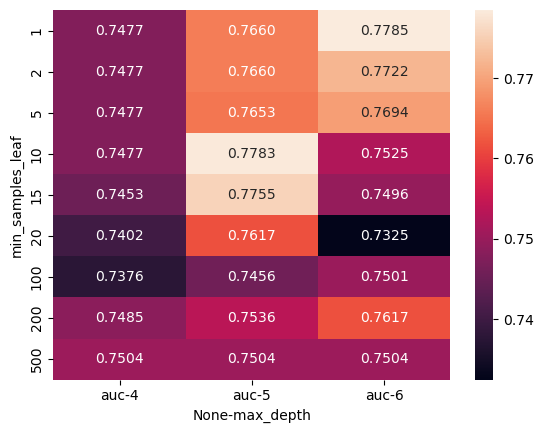

In [219]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
# df_scores.sort_values(by='auc', ascending=False)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
# df_scores_pivot

sns.heatmap(df_scores_pivot, annot=True, fmt='.4f')

Finally we find the best parameters as `max_depth=6` and `min_samples_leaf=1` with AUC of `0.7785` on validation dataset.

#### Full training set

In [221]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
dt.fit(X_full_train_res, y_full_train_res)

DecisionTreeClassifier(max_depth=6)

In [226]:
y_pred = dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_pred)
print(f"AUC Dtree on testing dataset: {round(auc_dt, 4)}")

AUC Dtree on testing dataset: 0.772


### Random Forest

In [224]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=10, random_state=42)

In [227]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred)
print(f"AUC RF on validation dataset: {round(auc_rf, 4)}")

AUC RF on validation dataset: 0.7242


#### Tuning number of estimators

In [234]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_res, y_train_res)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%3d -> %.3f' % (n, auc))
    scores.append((n, auc))

 10 -> 0.724
 20 -> 0.730
 30 -> 0.736
 40 -> 0.741
 50 -> 0.750
 60 -> 0.752
 70 -> 0.755
 80 -> 0.773
 90 -> 0.772
100 -> 0.768
110 -> 0.775
120 -> 0.773
130 -> 0.769
140 -> 0.776
150 -> 0.776
160 -> 0.778
170 -> 0.778
180 -> 0.778
190 -> 0.777
200 -> 0.776


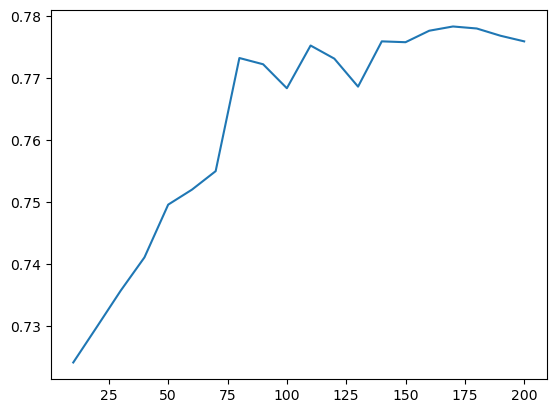

In [235]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

Based on the plot, we need another tweak with the number of max depth of trees in random forest 5, 10, 15

In [236]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train_res, y_train_res)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%3d %3d) -> %.3f' % (d, n, auc))
        scores.append((d, n, auc))

(  5  10) -> 0.765
(  5  20) -> 0.752
(  5  30) -> 0.756
(  5  40) -> 0.755
(  5  50) -> 0.757
(  5  60) -> 0.762
(  5  70) -> 0.758
(  5  80) -> 0.756
(  5  90) -> 0.755
(  5 100) -> 0.755
(  5 110) -> 0.756
(  5 120) -> 0.754
(  5 130) -> 0.754
(  5 140) -> 0.755
(  5 150) -> 0.755
(  5 160) -> 0.755
(  5 170) -> 0.754
(  5 180) -> 0.753
(  5 190) -> 0.751
(  5 200) -> 0.751
( 10  10) -> 0.726
( 10  20) -> 0.743
( 10  30) -> 0.755
( 10  40) -> 0.755
( 10  50) -> 0.755
( 10  60) -> 0.761
( 10  70) -> 0.763
( 10  80) -> 0.763
( 10  90) -> 0.763
( 10 100) -> 0.761
( 10 110) -> 0.763
( 10 120) -> 0.762
( 10 130) -> 0.763
( 10 140) -> 0.764
( 10 150) -> 0.764
( 10 160) -> 0.763
( 10 170) -> 0.763
( 10 180) -> 0.761
( 10 190) -> 0.761
( 10 200) -> 0.763
( 15  10) -> 0.688
( 15  20) -> 0.709
( 15  30) -> 0.749
( 15  40) -> 0.765
( 15  50) -> 0.763
( 15  60) -> 0.761
( 15  70) -> 0.757
( 15  80) -> 0.763
( 15  90) -> 0.760
( 15 100) -> 0.760
( 15 110) -> 0.771
( 15 120) -> 0.771
( 15 130) ->

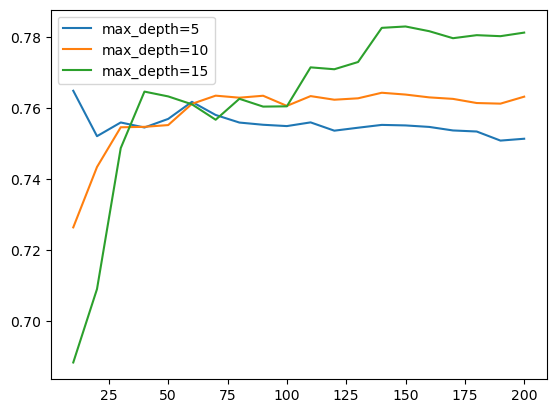

In [237]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

The best max depth would be 15 then let's tune again with `min_samples_leaf`

(  1  10) -> 0.688
(  1  20) -> 0.709
(  1  30) -> 0.749
(  1  40) -> 0.765
(  1  50) -> 0.763
(  1  60) -> 0.761
(  1  70) -> 0.757
(  1  80) -> 0.763
(  1  90) -> 0.760
(  1 100) -> 0.760
(  1 110) -> 0.771
(  1 120) -> 0.771
(  1 130) -> 0.773
(  1 140) -> 0.783
(  1 150) -> 0.783
(  1 160) -> 0.782
(  1 170) -> 0.780
(  1 180) -> 0.781
(  1 190) -> 0.780
(  1 200) -> 0.781
(  3  10) -> 0.734
(  3  20) -> 0.781
(  3  30) -> 0.783
(  3  40) -> 0.778
(  3  50) -> 0.784
(  3  60) -> 0.784
(  3  70) -> 0.782
(  3  80) -> 0.787
(  3  90) -> 0.787
(  3 100) -> 0.783
(  3 110) -> 0.781
(  3 120) -> 0.782
(  3 130) -> 0.782
(  3 140) -> 0.786
(  3 150) -> 0.786
(  3 160) -> 0.786
(  3 170) -> 0.785
(  3 180) -> 0.786
(  3 190) -> 0.786
(  3 200) -> 0.786
(  5  10) -> 0.771
(  5  20) -> 0.780
(  5  30) -> 0.788
(  5  40) -> 0.787
(  5  50) -> 0.791
(  5  60) -> 0.792
(  5  70) -> 0.792
(  5  80) -> 0.795
(  5  90) -> 0.795
(  5 100) -> 0.793
(  5 110) -> 0.790
(  5 120) -> 0.790
(  5 130) ->

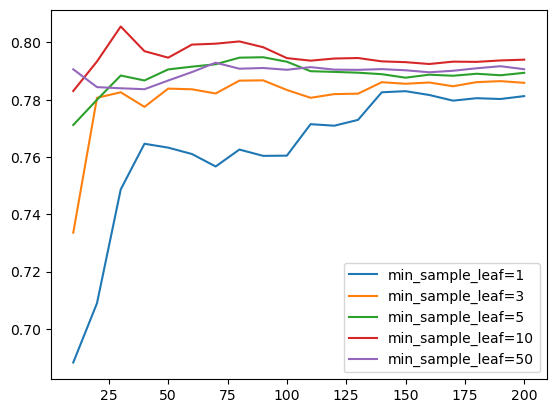

In [238]:
scores = []
max_depths = 15
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depths, min_samples_leaf=s, random_state=42)
        rf.fit(X_train_res, y_train_res)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%3d %3d) -> %.3f' % (s, n, auc))
        scores.append((s, n, auc))

df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'n_estimators', 'auc'])

for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_sample_leaf=%d' % s)

plt.legend()

In [240]:
# Final hyperparameters
numerical = 170
max_depths = 15
min_samples_leaf = 10
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depths, min_samples_leaf=min_samples_leaf, random_state=42)
rf.fit(X_full_train_res, y_full_train_res)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=200,
                       random_state=42)

In [241]:
y_pred = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred)
print(f"AUC RF on testing dataset: {round(auc_rf, 4)}")

AUC RF on testing dataset: 0.8258


#### Full training set

### XGBoost

In [245]:
# define function to parse xgboost output
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    df_results = pd.DataFrame(results, columns=['num_iter', 'auc_train', 'auc_val'])
        
    return df_results

In [244]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train_res, label=y_train_res, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [246]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [247]:
y_pred = model.predict(dval)
auc_xgb = roc_auc_score(y_val, y_pred)
print(f"AUC XGBoost on validation dataset: {round(auc_xgb, 4)}")

AUC XGBoost on validation dataset: 0.7706


In [248]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [249]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [250]:
s = output.stdout

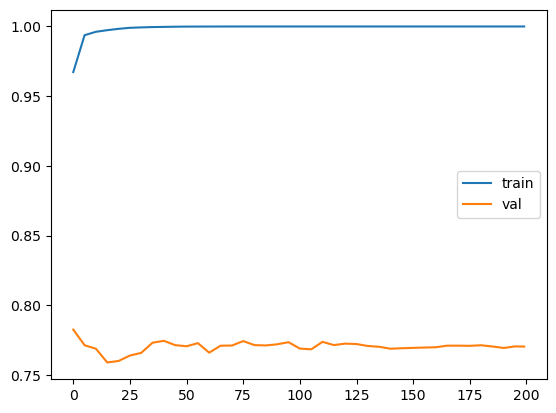

In [251]:
df_scores = parse_xgb_output(output)
plt.plot(df_scores.num_iter, df_scores.auc_train, label='train')
plt.plot(df_scores.num_iter, df_scores.auc_val, label='val')
plt.legend()

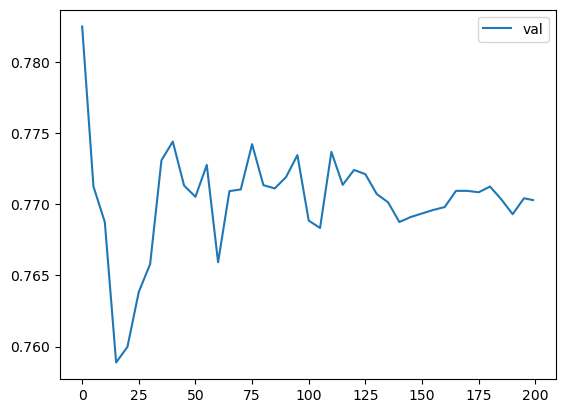

In [252]:
plt.plot(df_scores.num_iter, df_scores.auc_val, label='val')
plt.legend()

As we can see, there is an overfitting issue in values of 30 or 40 iterations.

#### Tuning hyperparameters

In [296]:
scores = {}

In [264]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [265]:
key = 'eta=%s' % xgb_params['eta']
scores[key] = parse_xgb_output(output)

In [266]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.1', 'eta=0.3'])

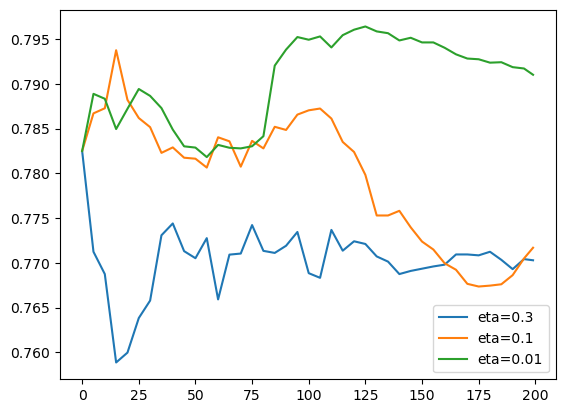

In [268]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.auc_val, label=eta)
plt.legend()

`eta=0.01` is the best learning rate parameter. Let's tune further with `max_depth` and `min_child_weight`

In [274]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [275]:
key = 'max_depth=%s' % xgb_params['max_depth']
scores[key] = parse_xgb_output(output)

In [276]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=6'])

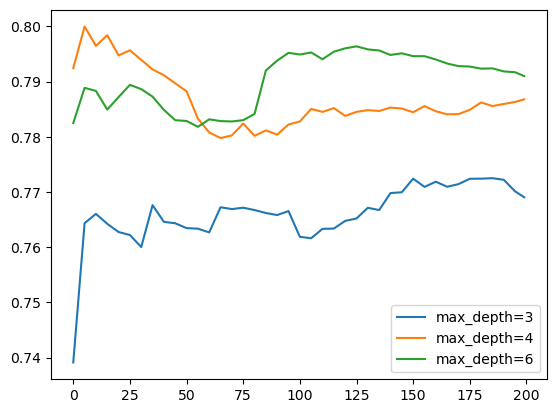

In [278]:
for max_depths, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.auc_val, label=max_depths)
# plt.ylim(0.8, 0.84)
plt.legend()

`max_depth=6` is the best parameter.

In [301]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [302]:
key = 'min_child_weight=%s' % xgb_params['min_child_weight']
scores[key] = parse_xgb_output(output)

In [303]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

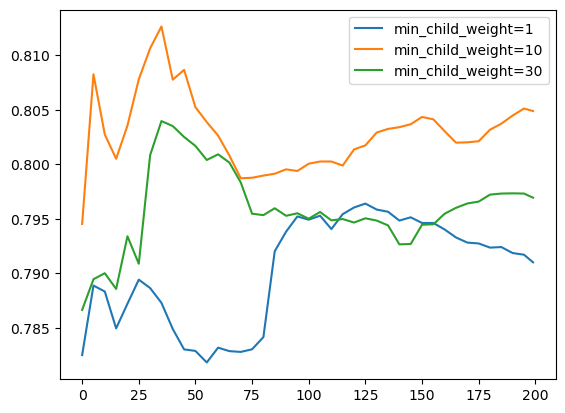

In [305]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.auc_val, label=min_child_weight)
plt.legend()

In [ ]:
# This is our final parameter set
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=175, verbose_eval=5)

[0]	train-auc:0.96345	val-auc:0.79452
[5]	train-auc:0.98085	val-auc:0.80825
[10]	train-auc:0.98190	val-auc:0.80273
[15]	train-auc:0.98352	val-auc:0.80050
[20]	train-auc:0.98489	val-auc:0.80355
[25]	train-auc:0.98577	val-auc:0.80779
[30]	train-auc:0.98597	val-auc:0.81063
[35]	train-auc:0.98664	val-auc:0.81264
[40]	train-auc:0.98678	val-auc:0.80776
[45]	train-auc:0.98660	val-auc:0.80866
[50]	train-auc:0.98688	val-auc:0.80523
[55]	train-auc:0.98712	val-auc:0.80387
[60]	train-auc:0.98745	val-auc:0.80263
[65]	train-auc:0.98786	val-auc:0.80079
[70]	train-auc:0.98810	val-auc:0.79871
[75]	train-auc:0.98834	val-auc:0.79876
[80]	train-auc:0.98856	val-auc:0.79896
[85]	train-auc:0.98885	val-auc:0.79913
[90]	train-auc:0.98916	val-auc:0.79953
[95]	train-auc:0.98940	val-auc:0.79938
[100]	train-auc:0.98964	val-auc:0.80005
[105]	train-auc:0.98985	val-auc:0.80025
[110]	train-auc:0.99008	val-auc:0.80025
[115]	train-auc:0.99028	val-auc:0.79988
[120]	train-auc:0.99059	val-auc:0.80136
[125]	train-auc:0.9908

#### Full training set

In [307]:
dfulltrain = xgb.DMatrix(X_full_train_res, label=y_full_train_res, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [ ]:
xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dfulltrain,  num_boost_round=175, verbose_eval=5)

In [309]:
y_pred = model.predict(dtest)
auc_xgb = roc_auc_score(y_test, y_pred)
print(f"AUC RF on testing dataset: {round(auc_xgb, 4)}")

AUC RF on testing dataset: 0.8035


## Summary

Finally we have the following AUC scores on the testing dataset:

| Model               | AUC    |
|---------------------|--------|
| Logistic Regression | `0.8426` |
| Decision Tree       | `0.7722` |
| Random Forest       | `0.8258` |
| XGBoost             | `0.8035` |

The model with the given data and parameters that performs the best is Logistic Regression.

### Write LR Model

In [310]:
import pickle

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

In [312]:
output_file = 'stroke_model.bin'
f_out = open(output_file, 'wb')
pickle.dump((dv, model), f_out)
f_out.close()